### Installation

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install prettytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install jsonpickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install -q transformers

### Import Packages

In [ ]:
import torch
import shutil
import os
import ast
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import sys 
import ast
import torch.nn as nn
import json
import transformers
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import json
import time
import gspread
import joblib
import time
import nltk
import string
import re
import traceback
import xgboost

from transformers import pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC
from numpy import where
from collections import Counter
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from typing import List
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertConfig, BertTokenizerFast, BertModel, BertPreTrainedModel, Trainer, TrainingArguments, AutoModelForSequenceClassification, AdamW, get_scheduler, BertForSequenceClassification, AutoModel
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from prettytable import PrettyTable
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from tqdm.auto import tqdm
from ast import literal_eval
from sklearn.utils.class_weight import compute_class_weight
from math import log2
from oauth2client.client import GoogleCredentials
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import warnings
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For emoticons

warnings.filterwarnings("ignore")

#### Some downloads

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Set Random Seed

In [ ]:
# specify GPU
device = torch.device("cuda")

In [ ]:
def set_seed(seed: int):
  """
  Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
  installed).

  Args:
      seed (:obj:`int`): The seed to set.
  """
  random.seed(seed)
  np.random.seed(seed)
  if is_torch_available():
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # safe to call this function even if cuda is not available
  if is_tf_available():
    import tensorflow as tf

    tf.random.set_seed(seed)

In [ ]:
set_seed(1)

### Read Input File

In [ ]:
# mounting gdrive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# dataset file directory
# infile = "/content/elonmusk_doge_tweets.csv"
infile = "/content/doge_coin_dataset_2021_orig.csv"
# infile = "/content/drive/MyDrive/SMBA_2022/elonmusk_doge_tweets.gsheet"

# reading the dataset
df = pd.read_csv(infile, encoding = "utf-8")
    

df.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,labels,Unnamed: 11,Unnamed: 12
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",1,NaN,NaN
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...,NaN,NaN,NaN
2,1.360000e+18,1.849860e+09,Nobody,"If you really hated socialism, you’d let every...",2021,1,31,23:28:42,Twitter for iPhone,"if you really hated socialism, you’d let every...",NaN,NaN,NaN
3,1.360000e+18,1.360000e+18,Nobody,"Like and retweet, if you believe #Dogecoin #in...",2021,1,31,23:28:35,Twitter for iPhone,"like and retweet, if you believe #dogecoin #in...",NaN,NaN,NaN
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,-1,NaN,NaN


### Preprocess the dataset

#### Collect all annotated tweets

In [ ]:
# drop unnamed columns 
df = df.drop(['Unnamed: 11', 'Unnamed: 12'], axis=1)
df.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,labels
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",1
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...,NaN
2,1.360000e+18,1.849860e+09,Nobody,"If you really hated socialism, you’d let every...",2021,1,31,23:28:42,Twitter for iPhone,"if you really hated socialism, you’d let every...",NaN
3,1.360000e+18,1.360000e+18,Nobody,"Like and retweet, if you believe #Dogecoin #in...",2021,1,31,23:28:35,Twitter for iPhone,"like and retweet, if you believe #dogecoin #in...",NaN
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,-1


In [ ]:
# drop missing columns
for i in df.keys():
    df.dropna(subset=[i], inplace=True)

In [ ]:
df.count()

tweet_id          1970
user_id           1970
user_name         1970
original_tweet    1970
year              1970
month             1970
day               1970
time              1970
source            1970
cleaned_tweet     1970
labels            1970
dtype: int64

In [ ]:
df.labels.unique()

array(['1', '-1', '2', '0', ' '], dtype=object)

In [ ]:
df = df[df.labels != " "]
df.count()

tweet_id          1963
user_id           1963
user_name         1963
original_tweet    1963
year              1963
month             1963
day               1963
time              1963
source            1963
cleaned_tweet     1963
labels            1963
dtype: int64

In [ ]:
df.labels.unique()

array(['1', '-1', '2', '0'], dtype=object)

#### Some methods for preprocessing

In [ ]:
# remove all numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

In [ ]:
# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:
# tokenize a string
def tokenize(text):
    word_tokens = word_tokenize(text)
    return word_tokens

In [ ]:
stop_words = set(stopwords.words("english"))

# remove stopwords function
def remove_stopwords(word_tokens):
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

In [ ]:
lemmatizer = WordNetLemmatizer()

# lemmatize string
def lemmatize_word(word_tokens):
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return lemmas

57


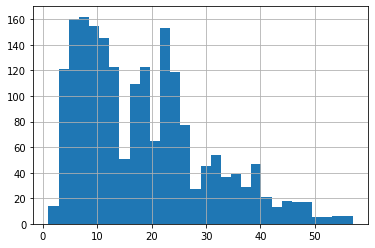

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df.cleaned_tweet]

print(max(seq_len))
pd.Series(seq_len).hist(bins = 30);

In [ ]:
# create the transform
vectorizer = HashingVectorizer(n_features=250)

# encode document
def hashing_vectorizer(text):
  vector = vectorizer.transform(text)
  return vector.toarray()[0]

In [ ]:
vec=TfidfVectorizer(stop_words='english', max_features=3500)

def tfidf(text):
  matrix=vec.fit_transform(text)

  return matrix.toarray()

In [ ]:
# method for removing emojis and emoticons
def convert_emojis_to_text(tweet):
    for emot in UNICODE_EMOJI:
        tweet = tweet.replace(emot, (UNICODE_EMOJI[emot].replace(",","").replace(":"," ").replace("_"," ")))
    return tweet

In [ ]:
# perform all the steps of pre-processing
def do_preprocoessing(df):
  preprocessed_tweet_ls = []
  encoded_tweet_ls = []
  for ix, row in df.iterrows():
    # remove numbers
    row.cleaned_tweet = remove_numbers(row.cleaned_tweet)

    # remove punctuation
    row.cleaned_tweet = remove_punctuation(row.cleaned_tweet)
    
    # convert emojis to text description
    # row.cleaned_tweet = convert_emojis_to_text(row.cleaned_tweet)

    # tokenize a string
    word_tokens = tokenize(row.cleaned_tweet)
    
    # remove stopwords
    word_tokens = remove_stopwords(word_tokens)
    
    # lemmatize a list of word
    word_tokens = lemmatize_word(word_tokens)

    # create a full string after pre-processing
    preprocessed_tweet = " ".join(word_tokens)
    preprocessed_tweet_ls.append(preprocessed_tweet)

    # # encode our string using hashing vectorizer
    # encoded_tweet_ls.append(hashing_vectorizer([preprocessed_tweet]))

  encoded_tweet_lss = tfidf(preprocessed_tweet_ls)
  for i in encoded_tweet_lss:
    encoded_tweet_ls.append(i)

  df["preprocessed_tweet"] = preprocessed_tweet_ls
  df["encoded_tweet"] = encoded_tweet_ls

  return df

In [ ]:
try:
  n_df = do_preprocoessing(df)
except:
  print(traceback.print_exc())

In [ ]:
n_df.encoded_tweet

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
55108    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
55372    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
55373    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.311...
55484    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
55627    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: encoded_tweet, Length: 1963, dtype: object

In [ ]:
n_df.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,labels,preprocessed_tweet,encoded_tweet
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",1,’ stop us fuck dogecoin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,-1,dogecoin sound like essential oil pyramid sche...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,1.360000e+18,2.966939e+09,Nobody,#dogecoin wasn’t meant to be a pump and dump. ...,2021,1,31,23:28:33,Twitter for iPhone,#dogecoin wasn’t meant to be a pump and dump. ...,-1,dogecoin ’ mean pump dump suppose buy hold eve...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1.360000e+18,1.360000e+18,Nobody,to spread the past week and xrp link https t h...,2021,1,31,23:28:31,Error-log,to spread the past week and xrp link https t h...,2,spread past week xrp link https make k doge al...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,1.360000e+18,1.350000e+18,Nobody,If every owner that owns a dog would put 10$ i...,2021,1,31,23:28:27,Twitter for iPhone,if every owner that owns a dog would put 10$ i...,1,every owner own dog would put dogecoin mfer wo...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Train-Test splits

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(list(n_df.encoded_tweet), n_df.labels.values.ravel(), test_size = 0.40, random_state = 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.50, random_state = 42)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

In [ ]:
X_train.shape

(1177, 3500)

dict_items([('2', 329), ('1', 390), ('0', 317), ('-1', 141)])


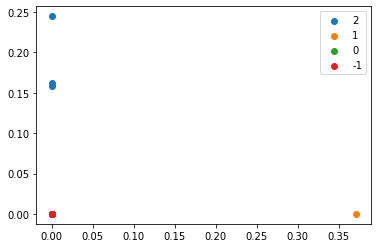

In [ ]:
# summarize observations by class label
counter = Counter(y_train)
print(counter.items())
# plot the dataset and color the by class label
for label, _ in counter.items():
  row_ix = where(y_train == label)[0]
  # print(row_ix)
  pyplot.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))

pyplot.legend()
pyplot.show()

In [ ]:
figure(figsize=(30, 14), dpi=80)

# summarize observations by class label
counter = Counter(y_train)
print(counter.items())
# plot the dataset and color the by class label
for label, _ in counter.items():
  row_ix = where(y_train == label)[0]
  
  feature_arr = np.array([])
  val_arr = np.array([])
  for i in row_ix:
    val = X_train[i, X_train[i] > 0]
    feature_idx = np.nonzero(X_train[i] > 0)

    feature_arr = np.concatenate([feature_arr, feature_idx[0].copy()])
    val_arr = np.concatenate([val_arr, val.copy()])

  pyplot.scatter(feature_arr, val_arr, label=str(label))

pyplot.legend()
pyplot.show()

### Train model

In [ ]:
# Print the best performed model and its parameters
def print_results(results):
  print(f"Best Parameters: {results.best_params_}\n")
  means = results.cv_results_["mean_test_score"]
  stds = results.cv_results_["std_test_score"]
  for mean, std, params in zip(means, stds, results.cv_results_["params"]):
    print(f"{round(mean, 3)} (+/- {round(std*2, 3)}) for {params}")

#### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators": [5, 50, 250, 500],
    "max_depth": [2, 4, 8, 16, 32, 64, None]
}

cv = GridSearchCV(rfc, parameters, cv=5)
cv.fit(X_train, y_train);

In [ ]:
print_results(cv)

Best Parameters: {'max_depth': 64, 'n_estimators': 50}

0.402 (+/- 0.072) for {'max_depth': 2, 'n_estimators': 5}
0.437 (+/- 0.037) for {'max_depth': 2, 'n_estimators': 50}
0.437 (+/- 0.038) for {'max_depth': 2, 'n_estimators': 250}
0.436 (+/- 0.037) for {'max_depth': 2, 'n_estimators': 500}
0.461 (+/- 0.022) for {'max_depth': 4, 'n_estimators': 5}
0.462 (+/- 0.03) for {'max_depth': 4, 'n_estimators': 50}
0.461 (+/- 0.036) for {'max_depth': 4, 'n_estimators': 250}
0.46 (+/- 0.03) for {'max_depth': 4, 'n_estimators': 500}
0.48 (+/- 0.063) for {'max_depth': 8, 'n_estimators': 5}
0.498 (+/- 0.048) for {'max_depth': 8, 'n_estimators': 50}
0.488 (+/- 0.056) for {'max_depth': 8, 'n_estimators': 250}
0.49 (+/- 0.043) for {'max_depth': 8, 'n_estimators': 500}
0.506 (+/- 0.045) for {'max_depth': 16, 'n_estimators': 5}
0.519 (+/- 0.04) for {'max_depth': 16, 'n_estimators': 50}
0.525 (+/- 0.042) for {'max_depth': 16, 'n_estimators': 250}
0.514 (+/- 0.048) for {'max_depth': 16, 'n_estimators': 500

In [ ]:
cv.best_estimator_

RandomForestClassifier(max_depth=64, n_estimators=50)

In [ ]:
# dump the best model
joblib.dump(cv.best_estimator_, "RFC_model.pkl")

['RFC_model.pkl']

#### Logistic Regression

In [ ]:
lr = LogisticRegression()
parameters = {
    "C": [0.1, 1, 10, 100]
}
cv1 = GridSearchCV(lr, parameters, cv=5)
cv1.fit(X_train, y_train);

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100]})

In [ ]:
print_results(cv1)

Best Parameters: {'C': 10}

0.474 (+/- 0.022) for {'C': 0.1}
0.533 (+/- 0.051) for {'C': 1}
0.541 (+/- 0.047) for {'C': 10}
0.52 (+/- 0.036) for {'C': 100}


In [ ]:
# dump the best model
joblib.dump(cv.best_estimator_, "LR_model.pkl")

['LR_model.pkl']

#### MultiLayerPerceptron

In [ ]:
mlp = MLPClassifier()
parameters = {
    "hidden_layer_sizes": [(10,), (50,), (100,)],
    "activation": ["relu", "tanh", "logistic"],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "early_stopping": [True]
}

cv2 = GridSearchCV(mlp, parameters, cv=5)
cv2.fit(X_train, y_train);

In [ ]:
print_results(cv2)

Best Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

0.502 (+/- 0.025) for {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.38 (+/- 0.199) for {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.421 (+/- 0.147) for {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.515 (+/- 0.025) for {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.507 (+/- 0.073) for {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.519 (+/- 0.054) for {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.533 (+/- 0.035) for {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_ra

In [ ]:
cv2.best_estimator_

MLPClassifier(early_stopping=True)

In [ ]:
# dump the best model
joblib.dump(cv2.best_estimator_, "MLP_model.pkl")

['MLP_model.pkl']

#### Support-vector-classifier

In [ ]:
svc = SVC()
parameters = {
    "C": [0.1, 1.0, 10],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "decision_function_shape": ["ovo", "ovr"]
}

cv3 = GridSearchCV(svc, parameters, cv=5)
cv3.fit(X_train, y_train);

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [ ]:
print_results(cv3)

Best Parameters: {'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'linear'}

0.422 (+/- 0.037) for {'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
0.416 (+/- 0.035) for {'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
0.416 (+/- 0.035) for {'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
0.42 (+/- 0.04) for {'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
0.422 (+/- 0.037) for {'C': 0.1, 'decision_function_shape': 'ovr', 'kernel': 'linear'}
0.416 (+/- 0.035) for {'C': 0.1, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
0.416 (+/- 0.035) for {'C': 0.1, 'decision_function_shape': 'ovr', 'kernel': 'poly'}
0.42 (+/- 0.04) for {'C': 0.1, 'decision_function_shape': 'ovr', 'kernel': 'sigmoid'}
0.545 (+/- 0.044) for {'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'linear'}
0.507 (+/- 0.042) for {'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
0.464 (+/- 0.041) for {'C': 1.0, 'decision_function_shape': 'o

In [ ]:
cv3.best_estimator_

SVC(decision_function_shape='ovo', kernel='linear')

In [ ]:
# dump the best model
joblib.dump(cv3.best_estimator_, "SVC_model.pkl")

['SVC_model.pkl']

#### Gradient Boosting Classifier

In [ ]:
gb = GradientBoostingClassifier()
parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [1, 3, 5],
    "learning_rate": [0.001, 0.01, 0.1, 1.0]
    # "learning_rate": [0.1]
}

cv4 = GridSearchCV(gb, parameters, cv=5)
cv4.fit(X_train, y_train);

KeyboardInterrupt: ignored

In [ ]:
print_results(cv4)

In [ ]:
cv4.best_estimator_

In [ ]:
# dump the best model
joblib.dump(cv4.best_estimator_, "GB_model.pkl")

#### Extreme Gradient Boosting 

In [ ]:
xgb = XGBClassifier()
parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [1, 3, 5],
    "learning_rate": [0.001, 0.01, 0.1, 1.0]
    # "learning_rate": [0.1]
}

cv5 = GridSearchCV(xgb, parameters, cv=5)
cv5.fit(X_train, y_train);

In [ ]:
print_results(cv5)

Best Parameters: {'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 100}

0.434 (+/- 0.06) for {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 50}
0.436 (+/- 0.058) for {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100}
0.443 (+/- 0.074) for {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 200}
0.51 (+/- 0.045) for {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50}
0.511 (+/- 0.046) for {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100}
0.507 (+/- 0.048) for {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 200}
0.523 (+/- 0.034) for {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 50}
0.517 (+/- 0.045) for {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100}
0.517 (+/- 0.039) for {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 200}
0.478 (+/- 0.051) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.477 (+/- 0.054) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}
0.482 

In [ ]:
cv5.best_estimator_

XGBClassifier(learning_rate=1.0, max_depth=1, objective='multi:softprob')

In [ ]:
# dump the best model
joblib.dump(cv5.best_estimator_, "XGB_model.pkl")

['XGB_model.pkl']

### Load Models

In [ ]:
models = {}
for model in [ "RFC", "MLP", "LR", "SVC",  "XGB"]:
  models[model] = joblib.load(model+"_model.pkl")

### Model selection on valid set

In [ ]:
# Evaluation function calculates accuracy, and f1-scores.
def eval_model(name, model, features, labels, ax, count):
  pred = model.predict(features)
  accuracy = round(accuracy_score(labels, pred), 3)
  precision = round(precision_score(labels, pred, average="weighted"), 3)
  recall = round(recall_score(labels, pred, average="weighted"), 3)
  f1score = round(f1_score(labels, pred, average="weighted"), 3)

  cf_matrix = confusion_matrix(labels, pred)
  disp = ConfusionMatrixDisplay(cf_matrix,
                                display_labels=[-1, 0, 1, 2])
  disp.plot(ax=ax[count], xticks_rotation=45)
  disp.ax_.set_title(name)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')
  print()
  print(f"{name} -- Accuracy: {accuracy} / Precision: {precision} / Recall: {recall} / F1-Score: {f1score}")
  print(classification_report(labels, pred))
  return pred, accuracy, precision, recall, f1score, disp


RFC -- Accuracy: 0.55 / Precision: 0.593 / Recall: 0.55 / F1-Score: 0.514
              precision    recall  f1-score   support

          -1       0.75      0.08      0.15        37
           0       0.55      0.27      0.36       126
           1       0.44      0.84      0.58       110
           2       0.73      0.72      0.73       120

    accuracy                           0.55       393
   macro avg       0.62      0.48      0.45       393
weighted avg       0.59      0.55      0.51       393


MLP -- Accuracy: 0.489 / Precision: 0.532 / Recall: 0.489 / F1-Score: 0.438
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        37
           0       0.56      0.18      0.28       126
           1       0.39      0.95      0.55       110
           2       0.80      0.53      0.64       120

    accuracy                           0.49       393
   macro avg       0.44      0.42      0.37       393
weighted avg       0.53      0.49

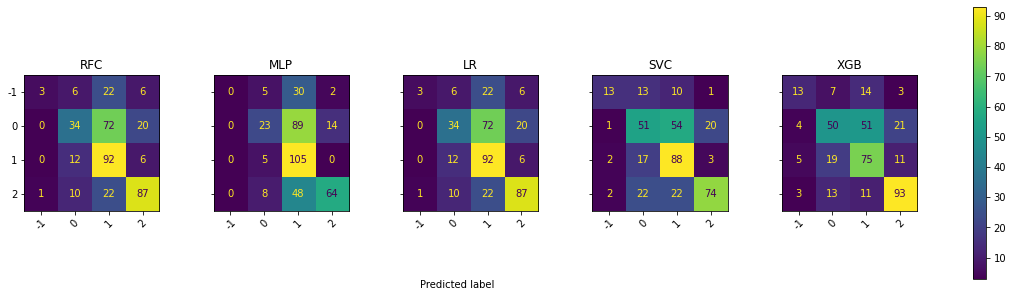

In [ ]:
# Evaluate on valid set to find the best model for our problem.
count = 0
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')
for name, model in models.items():
  _, _, _, _, _, disp = eval_model(name, model, X_valid, y_valid, axes, count)
  count += 1

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

### Evaluation on test set


MLP -- Accuracy: 0.501 / Precision: 0.493 / Recall: 0.501 / F1-Score: 0.44
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        42
           0       0.52      0.17      0.26       127
           1       0.42      0.90      0.57       122
           2       0.75      0.64      0.69       102

    accuracy                           0.50       393
   macro avg       0.42      0.43      0.38       393
weighted avg       0.49      0.50      0.44       393


SVC -- Accuracy: 0.573 / Precision: 0.566 / Recall: 0.573 / F1-Score: 0.556
              precision    recall  f1-score   support

          -1       0.53      0.21      0.31        42
           0       0.48      0.39      0.43       127
           1       0.55      0.75      0.63       122
           2       0.71      0.74      0.72       102

    accuracy                           0.57       393
   macro avg       0.57      0.52      0.52       393
weighted avg       0.57      0.5

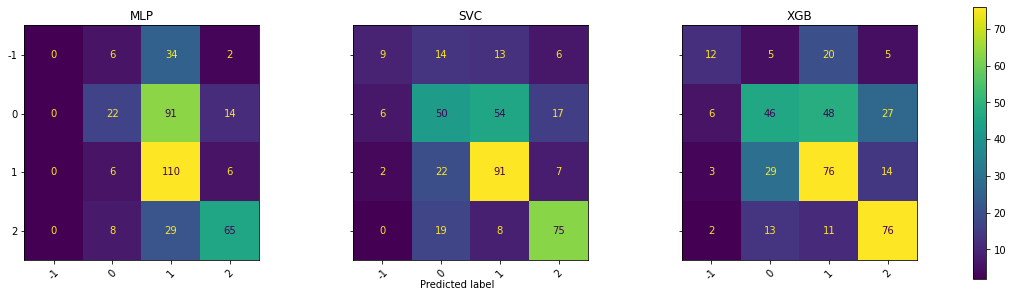

In [ ]:
count = 0
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')
try:
  for name, model in models.items():
    if name == "SVC" or name == "MLP" or name == "XGB":
      _, _, _, _, _, disp = eval_model(name, model, X_test, y_test, axes, count)
      count+=1
except:
  print(traceback.print_exc())

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

### Create encodings for overall datasets

In [ ]:
infile_1 = "/content/doge_coin_dataset_2021_orig.csv"
# infile = "/content/drive/MyDrive/SMBA_2022/elonmusk_doge_tweets.gsheet"

# reading the dataset
df_1 = pd.read_csv(infile_1, encoding = "utf-8")
    

df_1.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,labels,Unnamed: 11,Unnamed: 12
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",1,NaN,NaN
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...,NaN,NaN,NaN
2,1.360000e+18,1.849860e+09,Nobody,"If you really hated socialism, you’d let every...",2021,1,31,23:28:42,Twitter for iPhone,"if you really hated socialism, you’d let every...",NaN,NaN,NaN
3,1.360000e+18,1.360000e+18,Nobody,"Like and retweet, if you believe #Dogecoin #in...",2021,1,31,23:28:35,Twitter for iPhone,"like and retweet, if you believe #dogecoin #in...",NaN,NaN,NaN
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,-1,NaN,NaN


In [ ]:
# drop unnamed columns 
df_1 = df_1.drop(['Unnamed: 11', 'Unnamed: 12', "labels"], axis=1)
df_1.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin"
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...
2,1.360000e+18,1.849860e+09,Nobody,"If you really hated socialism, you’d let every...",2021,1,31,23:28:42,Twitter for iPhone,"if you really hated socialism, you’d let every..."
3,1.360000e+18,1.360000e+18,Nobody,"Like and retweet, if you believe #Dogecoin #in...",2021,1,31,23:28:35,Twitter for iPhone,"like and retweet, if you believe #dogecoin #in..."
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...


In [ ]:
try:
  n_df_1 = do_preprocoessing(df_1)
except:
  print(traceback.print_exc())

In [ ]:
n_df_1.count()

tweet_id              73390
user_id               73390
user_name             73390
original_tweet        73390
year                  73390
month                 73390
day                   73390
time                  73390
source                73390
cleaned_tweet         73390
preprocessed_tweet    73390
encoded_tweet         73390
dtype: int64

### Predict sentiment on overall dataset using ExtremeGradientBoosting

In [ ]:
full_encoded_tweet = np.array(list(n_df_1.encoded_tweet))

In [ ]:
full_encoded_tweet.shape

(73390, 3500)

In [ ]:
model = joblib.load("SVC_model.pkl")

In [ ]:
pred = model.predict(full_encoded_tweet)
df_1["predicted_labels"] = pred

In [ ]:
df_1.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,predicted_labels
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",0
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...,0
2,1.360000e+18,1.849860e+09,Nobody,"If you really hated socialism, you’d let every...",2021,1,31,23:28:42,Twitter for iPhone,"if you really hated socialism, you’d let every...",2
3,1.360000e+18,1.360000e+18,Nobody,"Like and retweet, if you believe #Dogecoin #in...",2021,1,31,23:28:35,Twitter for iPhone,"like and retweet, if you believe #dogecoin #in...",2
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,0


In [ ]:
# drop unnamed columns 
# df_1 = df_1.drop(['preprocessed_tweet', 'encoded_tweet'], axis=1)


In [ ]:
df_1.head(10)

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,predicted_labels
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",0
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...,0
2,1.360000e+18,1.849860e+09,Nobody,"If you really hated socialism, you’d let every...",2021,1,31,23:28:42,Twitter for iPhone,"if you really hated socialism, you’d let every...",2
3,1.360000e+18,1.360000e+18,Nobody,"Like and retweet, if you believe #Dogecoin #in...",2021,1,31,23:28:35,Twitter for iPhone,"like and retweet, if you believe #dogecoin #in...",2
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,0
5,1.360000e+18,2.966939e+09,Nobody,#dogecoin wasn’t meant to be a pump and dump. ...,2021,1,31,23:28:33,Twitter for iPhone,#dogecoin wasn’t meant to be a pump and dump. ...,2
6,1.360000e+18,1.360000e+18,Nobody,to spread the past week and xrp link https t h...,2021,1,31,23:28:31,Error-log,to spread the past week and xrp link https t h...,0
7,1.360000e+18,1.350000e+18,Nobody,If every owner that owns a dog would put 10$ i...,2021,1,31,23:28:27,Twitter for iPhone,if every owner that owns a dog would put 10$ i...,0
8,1.360000e+18,5.472402e+07,Nobody,Thank you all so much. We are really doing it ...,2021,1,31,23:28:19,Twitter for iPhone,thank you all so much. we are really doing it ...,0
9,1.360000e+18,2.301640e+09,Nobody,@risepage @tyler Sounds like a good time to ow...,2021,1,31,23:28:18,Twitter for iPhone,sounds like a good time to own some #dogecoin ...,2


In [ ]:
df_1.to_csv("doge_coin_dataset_2021_orig_pred_svg.csv", index=False, encoding='utf-8-sig')

In [ ]:
df_1[df_1.predicted_labels == '2'].count()

tweet_id            27630
user_id             27630
user_name           27630
original_tweet      27630
year                27630
month               27630
day                 27630
time                27630
source              27630
cleaned_tweet       27630
predicted_labels    27630
dtype: int64

In [ ]:
df_1.count()

tweet_id            73390
user_id             73390
user_name           73390
original_tweet      73390
year                73390
month               73390
day                 73390
time                73390
source              73390
cleaned_tweet       73390
predicted_labels    73390
dtype: int64

In [ ]:
df_new = df_1[df_1.predicted_labels !=  "2"]
df_new.count()

tweet_id            45760
user_id             45760
user_name           45760
original_tweet      45760
year                45760
month               45760
day                 45760
time                45760
source              45760
cleaned_tweet       45760
predicted_labels    45760
dtype: int64

### Sentiment Analysis using huggingface model


In [ ]:
df[df.labels == "1"].count()

tweet_id              622
user_id               622
user_name             622
original_tweet        622
year                  622
month                 622
day                   622
time                  622
source                622
cleaned_tweet         622
labels                622
preprocessed_tweet    622
encoded_tweet         622
dtype: int64

In [ ]:
df[df.labels == "0"].count()

tweet_id              570
user_id               570
user_name             570
original_tweet        570
year                  570
month                 570
day                   570
time                  570
source                570
cleaned_tweet         570
labels                570
preprocessed_tweet    570
encoded_tweet         570
dtype: int64

In [ ]:
df[df.labels == "-1"].count()

tweet_id              220
user_id               220
user_name             220
original_tweet        220
year                  220
month                 220
day                   220
time                  220
source                220
cleaned_tweet         220
labels                220
preprocessed_tweet    220
encoded_tweet         220
dtype: int64

In [ ]:
temp_df = df[df.labels != "2"]

In [ ]:
temp_df.count()

tweet_id              1412
user_id               1412
user_name             1412
original_tweet        1412
year                  1412
month                 1412
day                   1412
time                  1412
source                1412
cleaned_tweet         1412
labels                1412
preprocessed_tweet    1412
encoded_tweet         1412
dtype: int64

In [ ]:
true_labels = temp_df.labels.values.ravel()

In [ ]:
true_labels

array(['1', '-1', '-1', ..., '-1', '-1', '-1'], dtype=object)

In [ ]:
infile_1 = "/content/doge_coin_dataset_2021_orig_pred_svg.csv"
# infile = "/content/drive/MyDrive/SMBA_2022/elonmusk_doge_tweets.gsheet"

# reading the dataset
df_new = pd.read_csv(infile_1, encoding = "utf-8")
    

df_new.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,predicted_labels
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",0
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...,0
2,1.360000e+18,1.849860e+09,Nobody,"If you really hated socialism, you’d let every...",2021,1,31,23:28:42,Twitter for iPhone,"if you really hated socialism, you’d let every...",2
3,1.360000e+18,1.360000e+18,Nobody,"Like and retweet, if you believe #Dogecoin #in...",2021,1,31,23:28:35,Twitter for iPhone,"like and retweet, if you believe #dogecoin #in...",2
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,0


In [ ]:
df_new.count()

tweet_id            73390
user_id             73390
user_name           73390
original_tweet      73390
year                73390
month               73390
day                 73390
time                73390
source              73390
cleaned_tweet       73390
predicted_labels    73390
hugging_labels      73390
dtype: int64

In [ ]:
df_new = df_new[df_new.predicted_labels != 2]

In [ ]:
df_new.predicted_labels.unique()

array([ 0, -1,  1])

In [ ]:
df_new.count()

tweet_id            45760
user_id             45760
user_name           45760
original_tweet      45760
year                45760
month               45760
day                 45760
time                45760
source              45760
cleaned_tweet       45760
predicted_labels    45760
hugging_labels      45760
dtype: int64

In [ ]:
# collecting all tweets
cleaned_tweets = []
# preprocessed_tweets = []
row_tweets = []
for ix, row in df_new.iterrows():
  cleaned_tweets.append(row.cleaned_tweet)
  # preprocessed_tweets.append(row.preprocessed_tweet)
  row_tweets.append(row.original_tweet)

#### tried with sentiment-analysis model

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
def calculate_sentiments(sentiments):
  pos = 0
  neg = 0
  neu = 0
  mx_pos = -1
  mn_pos = 1
  mx_neg = -1
  mn_neg = 1

  for i in sentiments:
    if i["label"] == "POSITIVE":
      pos += 1
      mx_pos = max(mx_pos, i["score"])
      mn_pos = min(mn_pos, i["score"])
    elif i["label"] == "NEGATIVE":
      neg += 1
      mx_neg = max(mx_neg, i["score"])
      mn_neg = min(mn_neg, i["score"])
  print("Without Threshold:")
  print(f"Positive: {pos}, Negative: {neg}, Neutral: {neu}")
  print(f"max pos: {mx_pos}, min_pos: {mn_pos}")
  print(f"max neg: {mx_neg}, min_neg: {mn_neg}")
  print()
  
  pos = 0
  neg = 0
  neu = 0
  mx_pos = -1
  mn_pos = 1
  mx_neg = -1
  mn_neg = 1
  for i in sentiments:
    if i["label"] == "POSITIVE" and i["score"]>=0.95:
      pos += 1
      mx_pos = max(mx_pos, i["score"])
      mn_pos = min(mn_pos, i["score"])
    elif i["label"] == "NEGATIVE" and i["score"]>=0.99:
      neg += 1
      mx_neg = max(mx_neg, i["score"])
      mn_neg = min(mn_neg, i["score"])
    else:
      neu += 1 
  print("With Threshold:")
  print(f"Positive: {pos}, Negative: {neg}, Neutral: {neu}")
  print(f"max pos: {mx_pos}, min_pos: {mn_pos}")
  print(f"max neg: {mx_neg}, min_neg: {mn_neg}")

In [ ]:
sentiment_preprocessed = sentiment_pipeline(preprocessed_tweets)

In [ ]:
calculate_sentiments(sentiment_preprocessed)

Without Threshold:
Positive: 458, Negative: 954, Neutral: 0
max pos: 0.9998698234558105, min_pos: 0.5121402144432068
max neg: 0.999769389629364, min_neg: 0.5005103945732117

With Threshold:
Positive: 285, Negative: 400, Neutral: 727
max pos: 0.9998698234558105, min_pos: 0.9500617384910583
max neg: 0.999769389629364, min_neg: 0.9900588393211365


In [ ]:
sentiment_cleaned = sentiment_pipeline(cleaned_tweets)

In [ ]:
calculate_sentiments(sentiment_cleaned)

Without Threshold:
Positive: 490, Negative: 922, Neutral: 0
max pos: 0.9998775720596313, min_pos: 0.5046946406364441
max neg: 0.999812662601471, min_neg: 0.5018454194068909

With Threshold:
Positive: 371, Negative: 546, Neutral: 495
max pos: 0.9998775720596313, min_pos: 0.9500430226325989
max neg: 0.999812662601471, min_neg: 0.9900228381156921


#### tried with finiteautomata/bertweet-base-sentiment-analysis model

In [ ]:
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
def calculate_specific_sentiments(sentiments):
  pos = 0
  neg = 0
  neu = 0
  mx_pos = -1
  mn_pos = 1
  mx_neg = -1
  mn_neg = 1
  mx_neu = -1
  mn_neu = 1

  for i in sentiments:
    if i["label"] == "POS":
      pos += 1
      mx_pos = max(mx_pos, i["score"])
      mn_pos = min(mn_pos, i["score"])
    elif i["label"] == "NEG":
      neg += 1
      mx_neg = max(mx_neg, i["score"])
      mn_neg = min(mn_neg, i["score"])
    elif i["label"] == "NEU":
      neu += 1
      mx_neu = max(mx_neu, i["score"])
      mn_neu = min(mn_neu, i["score"])
  print("Without Threshold:")
  print(f"Positive: {pos}, Negative: {neg}, Neutral: {neu}")
  print(f"max pos: {mx_pos}, min_pos: {mn_pos}")
  print(f"max neg: {mx_neg}, min_neg: {mn_neg}")
  print(f"max neu: {mx_neu}, min_neu: {mn_neu}")
  print()

In [ ]:
sentiment_preprocessed = specific_model(preprocessed_tweets)

In [ ]:
calculate_specific_sentiments(sentiment_preprocessed)

Without Threshold:
Positive: 372, Negative: 154, Neutral: 886
max pos: 0.9920395612716675, min_pos: 0.4442497491836548
max neg: 0.9856780171394348, min_neg: 0.3813939094543457
max neu: 0.9761793613433838, min_neu: 0.481385201215744



In [ ]:
sentiment_cleaned = specific_model(cleaned_tweets)

In [ ]:
calculate_specific_sentiments(sentiment_cleaned)

Without Threshold:
Positive: 620, Negative: 189, Neutral: 603
max pos: 0.9928900003433228, min_pos: 0.45251837372779846
max neg: 0.9857599139213562, min_neg: 0.4234328866004944
max neu: 0.982138991355896, min_neu: 0.48225900530815125



#### tried with cardiffnlp/twitter-roberta-base-sentiment

In [ ]:
specific_model_1 = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment")

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

In [ ]:

def calculate_specific_sentiments_1(sentiments):
  pred_labels = []
  pos = 0
  neg = 0
  neu = 0
  mx_pos = -1
  mn_pos = 1
  mx_neg = -1
  mn_neg = 1
  mx_neu = -1
  mn_neu = 1

  for i in sentiments:
    if i["label"] == "LABEL_2":
      pos += 1
      mx_pos = max(mx_pos, i["score"])
      mn_pos = min(mn_pos, i["score"])
      pred_labels.append('1')
    elif i["label"] == "LABEL_0":
      neg += 1
      mx_neg = max(mx_neg, i["score"])
      mn_neg = min(mn_neg, i["score"])
      pred_labels.append('-1')
    elif i["label"] == "LABEL_1":
      neu += 1
      mx_neu = max(mx_neu, i["score"])
      mn_neu = min(mn_neu, i["score"])
      pred_labels.append('0')
  print("Without Threshold:")
  print(f"Positive: {pos}, Negative: {neg}, Neutral: {neu}")
  print(f"max pos: {mx_pos}, min_pos: {mn_pos}")
  print(f"max neg: {mx_neg}, min_neg: {mn_neg}")
  print(f"max neu: {mx_neu}, min_neu: {mn_neu}")
  print()
  return pred_labels

In [ ]:
# sentiment_preprocessed = specific_model_1(preprocessed_tweets)

In [ ]:
sentiment_cleaned = specific_model_1(cleaned_tweets)

KeyboardInterrupt: ignored

In [ ]:
# sentiment_row = specific_model_1(row_tweets)

In [ ]:
# pred_labels_processed = calculate_specific_sentiments_1(sentiment_preprocessed)

Without Threshold:
Positive: 320, Negative: 126, Neutral: 966
max pos: 0.9895087480545044, min_pos: 0.495410293340683
max neg: 0.9674898386001587, min_neg: 0.42513808608055115
max neu: 0.9338383078575134, min_neu: 0.4490620195865631



In [ ]:
pred_labels_cleaned = calculate_specific_sentiments_1(sentiment_cleaned)

In [ ]:
# pred_labels_row = calculate_specific_sentiments_1(sentiment_row)

Without Threshold:
Positive: 670, Negative: 189, Neutral: 553
max pos: 0.9930852651596069, min_pos: 0.4538476765155792
max neg: 0.9753134846687317, min_neg: 0.43236809968948364
max neu: 0.9349294900894165, min_neu: 0.3976808488368988



              precision    recall  f1-score   support

          -1       0.63      0.54      0.58       220
           0       0.56      0.54      0.55       570
           1       0.64      0.69      0.67       622

    accuracy                           0.61      1412
   macro avg       0.61      0.59      0.60      1412
weighted avg       0.61      0.61      0.61      1412

              precision    recall  f1-score   support

          -1       0.62      0.55      0.58       220
           0       0.57      0.56      0.57       570
           1       0.65      0.69      0.67       622

    accuracy                           0.62      1412
   macro avg       0.62      0.60      0.61      1412
weighted avg       0.61      0.62      0.61      1412

              precision    recall  f1-score   support

          -1       0.67      0.39      0.49       220
           0       0.45      0.77      0.57       570
           1       0.62      0.32      0.42       622

    accuracy        

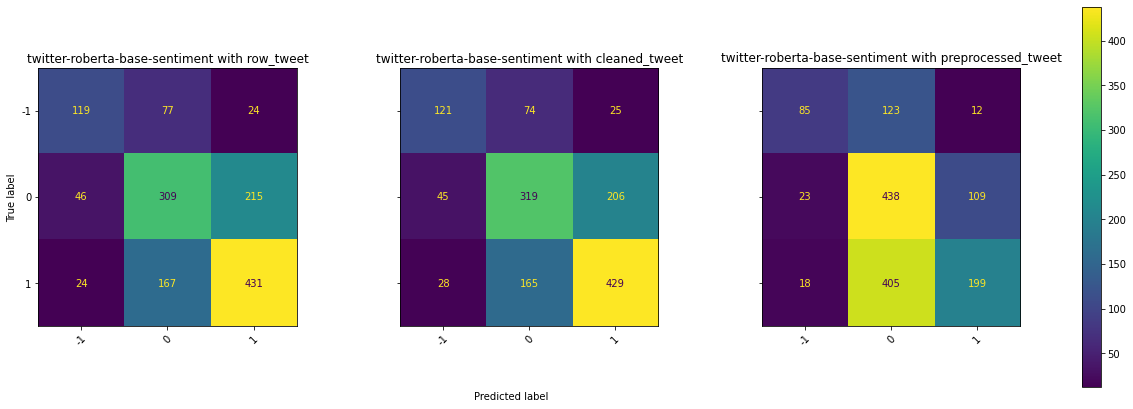

In [ ]:

# f, axes = plt.subplots(1, 3, figsize=(22, 7), sharey='row')
# name = ""
# for i,  pred in enumerate([pred_labels_row, pred_labels_cleaned, pred_labels_processed]):
#   if i == 0:
#     name = "row_tweet"
#   elif i == 1:
#     name = "cleaned_tweet"
#   else:
#     name = "preprocessed_tweet"
#   cf_matrix = confusion_matrix(true_labels, pred)
#   print(classification_report(true_labels, pred))
#   disp = ConfusionMatrixDisplay(cf_matrix,
#                                 display_labels=[-1, 0, 1])
#   disp.plot(ax=axes[i], xticks_rotation=45)
#   disp.ax_.set_title("twitter-roberta-base-sentiment with "+name)
#   disp.im_.colorbar.remove()
#   disp.ax_.set_xlabel('')
#   if i!=0:
#       disp.ax_.set_ylabel('')

# f.text(0.4, 0.1, 'Predicted label', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)


# f.colorbar(disp.im_, ax=axes)
# plt.show()

- For positive class it detects 4.5% as a negative! And most of the miss classified class are neutral, Which is 26% of neutral data!

-  For negative class it detects 10% as a positive! And most of the miss classified class are neutral, Which is 33.6% of neutral data! I think its because we dont have much data on negative thats why number is bit high in term of missclassified neutral class.
- For neutral class it detects 7.8% as a negative and 36.1% as a positive! Yeah we were also confused between positive and neutral class. 

In [ ]:
df_new["hugging_labels"] = pred_labels_cleaned

In [ ]:
df_new = df_new[df_new.predicted_labels != 2]

In [ ]:
df_new.head()

,tweet_id,user_id,user_name,original_tweet,year,month,day,time,source,cleaned_tweet,predicted_labels,hugging_labels
0,1.360000e+18,3.134341e+09,Nobody,"You can’t stop us, you fucks #dogecoin https:/...",2021,1,31,22:50:54,Twitter for iPhone,"you can’t stop us, you fucks #dogecoin",0,-1
1,1.360000e+18,1.320000e+18,Nobody,https://t.co/EGyJXssO6l\n\nLet's share it to t...,2021,1,31,23:28:43,Twitter for Android,let's share it to the entire social network to...,0,1
4,1.360000e+18,1.290000e+18,Nobody,#dogecoin is sounding more and more like essen...,2021,1,31,23:28:34,Twitter for Android,#dogecoin is sounding more and more like essen...,0,-1
6,1.360000e+18,1.360000e+18,Nobody,to spread the past week and xrp link https t h...,2021,1,31,23:28:31,Error-log,to spread the past week and xrp link https t h...,0,0
7,1.360000e+18,1.350000e+18,Nobody,If every owner that owns a dog would put 10$ i...,2021,1,31,23:28:27,Twitter for iPhone,if every owner that owns a dog would put 10$ i...,0,0


In [ ]:
df_new.to_csv("doge_coin_dataset_2021_final_set.csv", index=False, encoding='utf-8-sig')

#### tried with cardiffnlp/twitter-xlm-roberta-base-sentiment

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_path = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

In [ ]:
def calculate_specific_sentiments_2(sentiments):
  pos = 0
  neg = 0
  neu = 0
  mx_pos = -1
  mn_pos = 1
  mx_neg = -1
  mn_neg = 1
  mx_neu = -1
  mn_neu = 1
  pred_labels = []
  for i in sentiments:
    if i["label"] == "Positive":
      pos += 1
      mx_pos = max(mx_pos, i["score"])
      mn_pos = min(mn_pos, i["score"])
      pred_labels.append('1')
    elif i["label"] == "Negative":
      neg += 1
      mx_neg = max(mx_neg, i["score"])
      mn_neg = min(mn_neg, i["score"])
      pred_labels.append('-1')
    elif i["label"] == "Neutral":
      neu += 1
      mx_neu = max(mx_neu, i["score"])
      mn_neu = min(mn_neu, i["score"])
      pred_labels.append('0')
  print("Without Threshold:")
  print(f"Positive: {pos}, Negative: {neg}, Neutral: {neu}")
  print(f"max pos: {mx_pos}, min_pos: {mn_pos}")
  print(f"max neg: {mx_neg}, min_neg: {mn_neg}")
  print(f"max neu: {mx_neu}, min_neu: {mn_neu}")
  print()
  # pred_labels = np.ndarray(pred_labels)
  return pred_labels

In [ ]:
sentiment_preprocessed_1 = sentiment_task(preprocessed_tweets)

In [ ]:
sentiment_cleaned_1 = sentiment_task(cleaned_tweets)

In [ ]:
pred_labels_processed_1 = calculate_specific_sentiments_2(sentiment_preprocessed_1)

Without Threshold:
Positive: 269, Negative: 216, Neutral: 927
max pos: 0.8598459362983704, min_pos: 0.358956515789032
max neg: 0.9415497779846191, min_neg: 0.34559565782546997
max neu: 0.8914984464645386, min_neu: 0.34731271862983704



In [ ]:
pred_labels_cleaned_1 = calculate_specific_sentiments_2(sentiment_cleaned_1)

Without Threshold:
Positive: 509, Negative: 297, Neutral: 606
max pos: 0.9303633570671082, min_pos: 0.35855457186698914
max neg: 0.9620096683502197, min_neg: 0.3574495017528534
max neu: 0.8962258696556091, min_neu: 0.3446488082408905



              precision    recall  f1-score   support

          -1       0.50      0.68      0.58       220
           0       0.54      0.58      0.56       570
           1       0.66      0.54      0.59       622

    accuracy                           0.58      1412
   macro avg       0.57      0.60      0.58      1412
weighted avg       0.59      0.58      0.58      1412

              precision    recall  f1-score   support

          -1       0.47      0.46      0.46       220
           0       0.46      0.75      0.57       570
           1       0.65      0.28      0.39       622

    accuracy                           0.50      1412
   macro avg       0.53      0.50      0.48      1412
weighted avg       0.54      0.50      0.48      1412



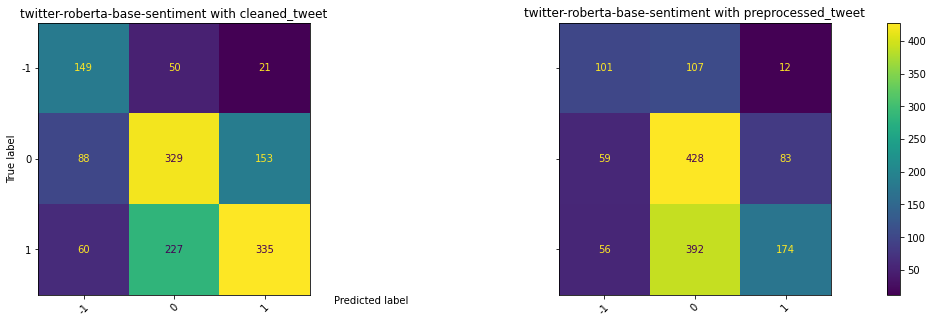

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')
name = ""
for i,  pred in enumerate([pred_labels_cleaned_1, pred_labels_processed_1]):
  if i == 0:
    name = "cleaned_tweet"
  else:
    name = "preprocessed_tweet"
  cf_matrix = confusion_matrix(true_labels, pred)
  print(classification_report(true_labels, pred))
  disp = ConfusionMatrixDisplay(cf_matrix,
                                display_labels=[-1, 0, 1])
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title("twitter-roberta-base-sentiment with "+name)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()